In [7]:
from scipy.io import arff
import pandas as pd
import numpy as np
import pydantic
import copy
import matplotlib.pyplot as plt
from typing import Union, Any

from pydantic import BaseModel, Field
from typing import List, Optional, Tuple
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [8]:
# compute metric

def if_empty_zero(array: np.array) -> np.array:
    if array.size == 0:
        array = 0

    return np.array(array)


def compute_variance_contribution(cov: np.array, comp: np.array, k: int, l: int, d: int) -> float:

    first_term = comp[k, l] ** 2 * cov[l, l]

    f1 = comp[k, :l] * comp[k, l] * cov[:l, l]
    f2 = comp[k, l+1:d] * comp[k, l] * cov[l+1:d, l]

    second_term = np.sum(if_empty_zero(f1)) + np.sum(if_empty_zero(f2))
    contribution = first_term + second_term

    return contribution


def get_contribs(cov: np.array, comp: int, p: int) -> np.array:
    arr_contrib = [[] for _ in range(p)]

    for pc_num in range(p):
        for feature_num in range(p):
            contrib = compute_variance_contribution(cov, comp, pc_num, feature_num, p)
            arr_contrib[pc_num].append(contrib)

    return np.array(arr_contrib)


def get_pca(data: np.array) -> tuple[PCA, np.array]:

    data = scale(data, axis=0)
    pca = PCA(n_components=data.shape[1])
    
    pca.fit(data)
    pca_transformed_data = pca.transform(data)

    return pca, pca_transformed_data


def compute_fitness(data_transformed: np.array,
                    training_mode: bool = True,
                    partial_contribution_objective: bool = False,
                    k: int = 1) -> Union[list, Any]:

    data_transformed = scale(data_transformed, axis=0)

    pca_model, pca_transformed_data = get_pca(copy.deepcopy(data_transformed))
    p = data_transformed.shape[1]
    cov_matrix = np.cov(np.transpose(data_transformed))

    variance_contrib = get_contribs(cov_matrix, pca_model.components_, p)

    if partial_contribution_objective:
        score = np.sum(variance_contrib[:k], axis=0)
    else:
        score = [np.sum(variance_contrib[:k])]*p

    return score, pca_transformed_data


# preprocess data

In [133]:
def preprocess_data(data: pd.DataFrame, dataset: str):

    if dataset in ["phoneme", "breast_cancer"]:
        type_class = data["Class"]

    elif dataset == "abalone":
        type_class = data["sex"]

    elif dataset in ["wine", "ionosphere", "german_credit", "dermatology", "heart-statlog"]:
        type_class = data["class"]

    return data, type_class

# perform the variance contrib on data

In [134]:
def read_arff(path):
    data, meta = arff.loadarff(path)
    data = pd.DataFrame(data)
    return data

In [135]:
dataset = "heart-statlog" # phoneme, zoo

In [136]:
path = f"../datasets/{dataset}.arff"

In [137]:
data = read_arff(path)
data = data.dropna()

In [138]:
data.shape

(270, 14)

In [139]:
data, type_class = preprocess_data(data, dataset)

In [140]:
type_class, mapping = pd.factorize(type_class)

In [141]:
print(data.shape, data.columns)

(270, 14) Index(['age', 'sex', 'chest', 'resting_blood_pressure', 'serum_cholestoral',
       'fasting_blood_sugar', 'resting_electrocardiographic_results',
       'maximum_heart_rate_achieved', 'exercise_induced_angina', 'oldpeak',
       'slope', 'number_of_major_vessels', 'thal', 'class'],
      dtype='object')


In [142]:
# Apply factorize on all object columns and replace them in the DataFrame
for col in data.select_dtypes(include=['object']).columns:
    data[col], _ = pd.factorize(data[col])

In [143]:
data

,age,sex,chest,resting_blood_pressure,serum_cholestoral,fasting_blood_sugar,resting_electrocardiographic_results,maximum_heart_rate_achieved,exercise_induced_angina,oldpeak,slope,number_of_major_vessels,thal,class
0,70.0,1.0,4.0,130.0,322.0,0.0,2.0,109.0,0.0,2.4,2.0,3.0,3.0,0
1,67.0,0.0,3.0,115.0,564.0,0.0,2.0,160.0,0.0,1.6,2.0,0.0,7.0,1
2,57.0,1.0,2.0,124.0,261.0,0.0,0.0,141.0,0.0,0.3,1.0,0.0,7.0,0
3,64.0,1.0,4.0,128.0,263.0,0.0,0.0,105.0,1.0,0.2,2.0,1.0,7.0,1
4,74.0,0.0,2.0,120.0,269.0,0.0,2.0,121.0,1.0,0.2,1.0,1.0,3.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,52.0,1.0,3.0,172.0,199.0,1.0,0.0,162.0,0.0,0.5,1.0,0.0,7.0,1
266,44.0,1.0,2.0,120.0,263.0,0.0,0.0,173.0,0.0,0.0,1.0,0.0,7.0,1
267,56.0,0.0,2.0,140.0,294.0,0.0,2.0,153.0,0.0,1.3,2.0,0.0,3.0,1
268,57.0,1.0,4.0,140.0,192.0,0.0,0.0,148.0,0.0,0.4,2.0,0.0,6.0,1


In [144]:
data_numerical = scale(data, axis=0)

In [145]:
print(data_numerical.shape)

(270, 14)


In [146]:
print(np.array(compute_fitness(data_numerical, k=1)[0])/data_numerical.shape[1])

[0.2578649 0.2578649 0.2578649 0.2578649 0.2578649 0.2578649 0.2578649
 0.2578649 0.2578649 0.2578649 0.2578649 0.2578649 0.2578649 0.2578649]


In [147]:
pca = PCA()
pca.fit(data_numerical)

x_pca = pca.transform(data_numerical)
print(pca.explained_variance_ratio_)

[0.25690984 0.11635208 0.08883022 0.08523647 0.07296537 0.06496323
 0.06011651 0.0537847  0.0487716  0.04118226 0.03239827 0.03025938
 0.02446322 0.02376684]


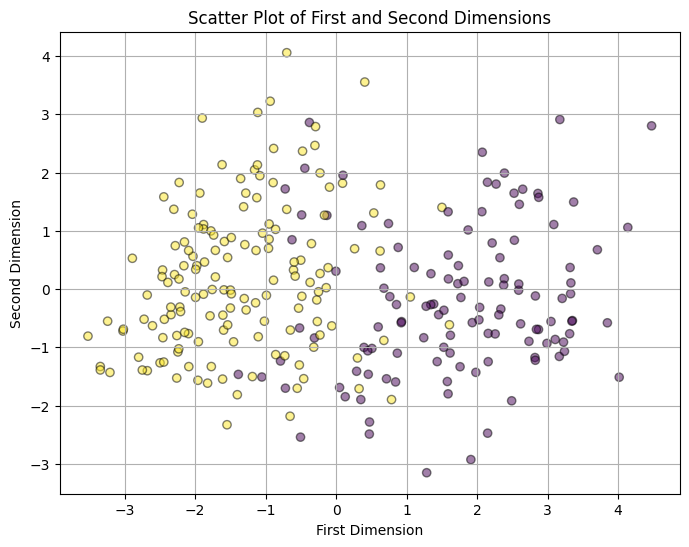

In [148]:
plt.figure(figsize=(8, 6))
plt.grid(True)
plt.scatter(x_pca[:, 0], x_pca[:, 1], alpha=0.5,  edgecolor="k", c=type_class)
plt.xlabel('First Dimension')
plt.ylabel('Second Dimension')
plt.title('Scatter Plot of First and Second Dimensions')
plt.show()